# Wikdata/Wikibase -> Pandas dataframe 
version 1.1 
* This [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Wikdata%20-%3E%20Panda%20dataset.ipynb)
* Suggested as an option in WDQS see [T257117](https://phabricator.wikimedia.org/T257117)

Example how Wikidata result can be transfered to a Pandas dataframe

In [14]:
import json,sys
import pandas as pd 
from SPARQLWrapper import SPARQLWrapper, JSON
endpoint_url = "https://query.wikidata.org/sparql"

query = """# Museums in Barcelona with coordinates
SELECT ?item ?itemLabel ?coord ?lon ?lat
WHERE
{
 ?item wdt:P131 wd:Q1492.   # in the administrative territory of Barcelona
 ?item wdt:P31 wd:Q33506.   # is a museum
 ?item p:P625 ?coordinate.
 ?coordinate ps:P625 ?coord.
 ?coordinate psv:P625 ?coordinate_node.
 ?coordinate_node wikibase:geoLongitude ?lon.
 ?coordinate_node wikibase:geoLatitude ?lat.  
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } 
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)



In [15]:
results = get_sparql_dataframe(endpoint_url, query)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
item         25 non-null object
itemLabel    25 non-null object
coord        25 non-null object
lon          25 non-null object
lat          25 non-null object
dtypes: object(5)
memory usage: 1.1+ KB


In [16]:
results

,item,itemLabel,coord,lon,lat
0,http://www.wikidata.org/entity/Q1630272,Museu Frederic Marès,Point(2.17667 41.3844),2.17667,41.3844
1,http://www.wikidata.org/entity/Q1872977,Museum of Modern Art,Point(2.18045833 41.38499167),2.18045833,41.38499167
2,http://www.wikidata.org/entity/Q4889477,Design Museum of Barcelona,Point(2.1875 41.40222222),2.1875,41.40222222
3,http://www.wikidata.org/entity/Q11939856,Palau de Mar,Point(2.18573 41.38094),2.18573,41.38094
4,http://www.wikidata.org/entity/Q18008863,Vil·la Joana,Point(2.09981 41.4198),2.09981,41.4198
5,http://www.wikidata.org/entity/Q30076932,Espai Subirachs,Point(2.197711111 41.404116666),2.1977111111111,41.404116666667
6,http://www.wikidata.org/entity/Q20949793,Museo Fran Daurel,Point(2.146944444 41.368888888),2.14694444444,41.3688888889
7,http://www.wikidata.org/entity/Q634421,Centre de Documentació i Museu de les Arts Esc...,Point(2.15775 41.37119722),2.15775,41.37119722
8,http://www.wikidata.org/entity/Q11938066,Museum of Ideas and Inventions,Point(2.17808333 41.38221667),2.17808333,41.38221667
9,http://www.wikidata.org/entity/Q11938072,Museu de Cultures del Món,Point(2.18088 41.385106),2.18088,41.385106


## Another example
I guess also pandas can be used to check quality as Python and Pandas is used much more that SPARQL federation etc...

In [77]:
querySwedishParish = """SELECT ?item ?itemLabel ?img  ?coord ?NAD ?article WHERE {
  ?item wdt:P31/wdt:P279* wd:Q615980 .
  OPTIONAL {?item wdt:P5324  ?itemk} 
  OPTIONAL {?item wdt:P18 ?img}
  OPTIONAL {?item wdt:P625 ?coord}
  BIND (CONCAT("NAD ",?itemk) as ?itemKod)
  BIND (URI(CONCAT("https://sok.riksarkivet.se/?postid=ArkisRef",?itemk)) as ?NAD)
  OPTIONAL{ ?item wdt:P571 ?StartD .} 		
  OPTIONAL{ ?item wdt:P576 ?SlutD .} 		
  
  BIND(IF((!BOUND(?SlutD) || ?SlutD > "2008-01-01T00:00:00Z"^^xsd:dateTime ) ,
          URI(CONCAT("http://geodata.scb.se/reginawebmap/main/webapp/?typ=forsamling&f=",?SCBid)),?SCBid) AS ?SCB).

  OPTIONAL{?item wdt:P6192 ?Bygdebandid} 						
  BIND (URI(CONCAT("http://www.bygdeband.se/plats/",?Bygdebandid)) AS ?Bygdeband)

  OPTIONAL {
      ?article schema:about ?item .
      ?article schema:inLanguage "sv" .
      ?article schema:isPartOf <https://sv.wikipedia.org/> .
    }  
  OPTIONAL {?item wdt:P131 ?admin}
  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv". }
}
order by ?NAD"""

In [78]:
 
results = get_sparql_dataframe(endpoint_url, querySwedishParish)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 6 columns):
item         3789 non-null object
itemLabel    3789 non-null object
img          3302 non-null object
coord        3404 non-null object
NAD          2847 non-null object
article      3783 non-null object
dtypes: object(6)
memory usage: 177.7+ KB


In [79]:
results.head()

,item,itemLabel,img,coord,NAD,article
0,http://www.wikidata.org/entity/Q10430483,Bjärke församling,http://commons.wikimedia.org/wiki/Special:File...,Point(12.51995 58.1118),None,https://sv.wikipedia.org/wiki/Bj%C3%A4rke_f%C3...
1,http://www.wikidata.org/entity/Q10430483,Bjärke församling,http://commons.wikimedia.org/wiki/Special:File...,Point(12.51995 58.1118),None,https://sv.wikipedia.org/wiki/Bj%C3%A4rke_f%C3...
2,http://www.wikidata.org/entity/Q10430495,Bjärreds församling,http://commons.wikimedia.org/wiki/Special:File...,Point(13.070277777 55.725833333),None,https://sv.wikipedia.org/wiki/Bj%C3%A4rreds_f%...
3,http://www.wikidata.org/entity/Q10430551,Björkekärrs församling,http://commons.wikimedia.org/wiki/Special:File...,Point(12.04696 57.71447),None,https://sv.wikipedia.org/wiki/Bj%C3%B6rkek%C3%...
4,http://www.wikidata.org/entity/Q10430587,Björklinge pastorat,None,None,None,https://sv.wikipedia.org/wiki/Bj%C3%B6rklinge-...


In [80]:
queryAcademyWinners = """#Winner of the Academy Awards by Award and Time
SELECT DISTINCT ?item ?itemLabel ?awardLabel ?time
{
    ?item wdt:P106/wdt:P279* wd:Q3455803 ; # Items with the Occupation(P106) of Director(Q3455803) or a subclass(P279)
          p:P166 ?awardStat .              # ... with an awarded(P166) statement
    ?awardStat pq:P805 ?award ;            # Get the award (which is "subject of" XXth Academy Awards)
               ps:P166 wd:Q103360 .        # ... that has the value Academy Award for Best Director(Q103360)
    ?award wdt:P585 ?time .                # the "point of time" of the Academy Award
    SERVICE wikibase:label {               # ... include the labels
        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en"
    }
}
ORDER BY DESC(?time)""" 

 
resultsAward = get_sparql_dataframe(endpoint_url, queryAcademyWinners)
resultsAward.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 4 columns):
item          92 non-null object
itemLabel     92 non-null object
awardLabel    92 non-null object
time          92 non-null object
dtypes: object(4)
memory usage: 3.0+ KB


In [81]:
%matplotlib inline  
import matplotlib.pyplot as plt   
resultsAward.time.value_counts().sort_index()

1930-04-03T00:00:00Z    1
1930-11-05T00:00:00Z    1
1931-11-10T00:00:00Z    1
1932-11-18T00:00:00Z    1
1934-03-16T00:00:00Z    1
                       ..
2015-02-22T00:00:00Z    1
2016-02-28T00:00:00Z    1
2017-02-26T00:00:00Z    1
2018-03-04T00:00:00Z    1
2020-02-09T00:00:00Z    1
Name: time, Length: 90, dtype: int64

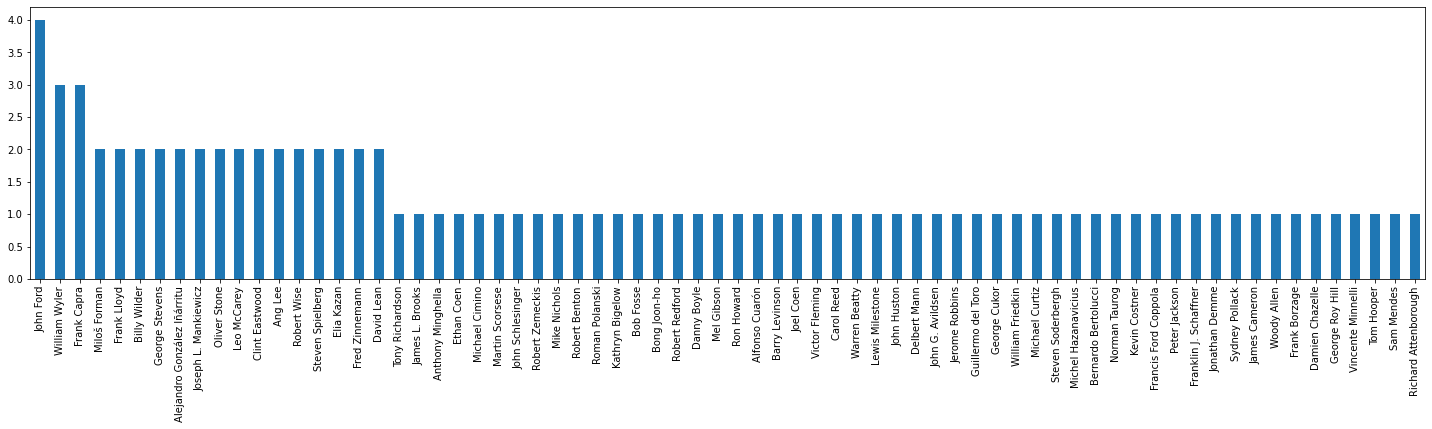

In [82]:
%matplotlib inline  
import matplotlib.pyplot as plt   
plot = resultsAward.itemLabel.value_counts().plot.bar(y='counts', figsize=(25, 5)) 
plt.show()

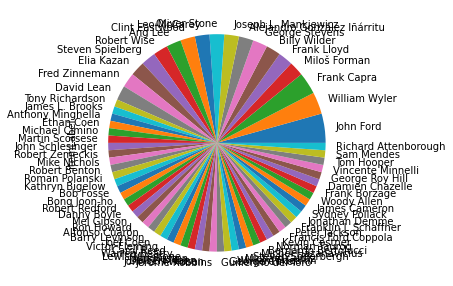

In [83]:
plot = resultsAward.itemLabel.value_counts().plot.pie(y='counts', figsize=(25, 5)) 
plt.show()

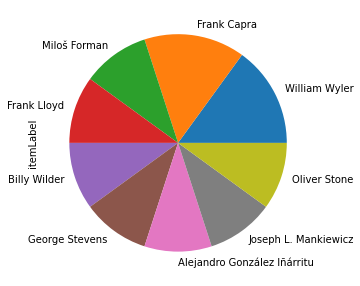

In [90]:
plot = resultsAward.itemLabel.value_counts()[1:10].plot.pie(y='counts', figsize=(25, 5)) 
plt.show()

In [84]:
queryGermanStates = """
SELECT
	?state ?stateLabel
	?companies
	?population
	(?companies/?population*1000000 AS ?companiesPerM)
WHERE
{
	{ SELECT ?state (count(*) as ?companies) WHERE {
		{SELECT DISTINCT ?company ?state WHERE {
			?state wdt:P31 wd:Q1221156 .
			?company wdt:P31/wdt:P279* wd:Q4830453 .
			?company wdt:P159/wdt:P131* ?state .
			FILTER NOT EXISTS{ ?company wdt:P576 ?date } # don't count dissolved companies
		} }
	} GROUP BY ?state  }
    ?state wdt:P1082 ?population
	SERVICE wikibase:label { bd:serviceParam wikibase:language "de" }
}
ORDER BY DESC(?companiesPerM)"""   

resultsGermanStates = get_sparql_dataframe(endpoint_url, queryGermanStates)
resultsGermanStates.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
state            16 non-null object
stateLabel       16 non-null object
companies        16 non-null object
population       16 non-null object
companiesPerM    16 non-null object
dtypes: object(5)
memory usage: 768.0+ bytes


In [85]:
resultsGermanStates.head() 

,state,stateLabel,companies,population,companiesPerM
0,http://www.wikidata.org/entity/Q1055,Hamburg,720,1841179,391.05377586861462
1,http://www.wikidata.org/entity/Q64,Berlin,1263,3644826,346.5185992417745
2,http://www.wikidata.org/entity/Q1209,Freie Hansestadt Bremen,199,661000,301.0590015128593
3,http://www.wikidata.org/entity/Q980,Bayern,2431,12930751,188.00145482656034
4,http://www.wikidata.org/entity/Q1199,Hessen,1173,6265809,187.20647246030002


In [86]:
resultsGermanStates.head() 
resultsGermanStates['companies'] = resultsGermanStates['companies'].astype(int)  
resultsGermanStates['population'] = resultsGermanStates['population'].astype(int)  
resultsGermanStates.set_index('stateLabel',inplace=True)
resultsGermanStates.info() 


<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, Hamburg to Brandenburg
Data columns (total 4 columns):
state            16 non-null object
companies        16 non-null int64
population       16 non-null int64
companiesPerM    16 non-null object
dtypes: int64(2), object(2)
memory usage: 640.0+ bytes


In [87]:
resultsGermanStates.head() 

,state,companies,population,companiesPerM
stateLabel,,,,
Hamburg,http://www.wikidata.org/entity/Q1055,720,1841179,391.05377586861462
Berlin,http://www.wikidata.org/entity/Q64,1263,3644826,346.5185992417745
Freie Hansestadt Bremen,http://www.wikidata.org/entity/Q1209,199,661000,301.0590015128593
Bayern,http://www.wikidata.org/entity/Q980,2431,12930751,188.00145482656034
Hessen,http://www.wikidata.org/entity/Q1199,1173,6265809,187.20647246030002


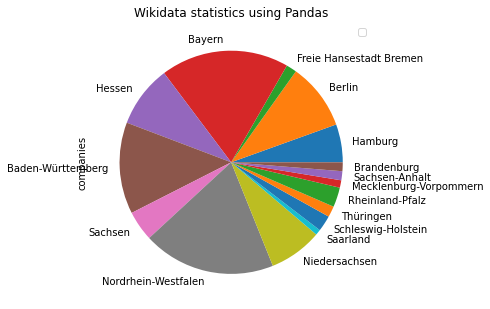

In [88]:
plotGerman = resultsGermanStates.plot.pie(title='Wikidata statistics using Pandas',x='stateLabel', y='companies', figsize=(5, 25)) 
plotGerman.legend([]);
plt.show() 


# Wikibase Factgrid -> pandas -> Kepler.gl
<a id="facgrid"></a>
Gets letters sent and try to display it using [Kepler.gl](https://github.com/keplergl/kepler.gl)  

* [The Illuminati Correspondence Fast Forward](https://blog.factgrid.de/archives/1695) the blogpost we should try to do in Jupyter
* [Create a Quick Web Map with Kepler.gl and Jupyter Notebook](https://spatial.blog.ryerson.ca/2019/11/18/create-quick-dashboard-with-kepler-gl-and-jupyter-notebook/)
* Video [Visualization Nights - Introduction to Kepler.gl](https://www.youtube.com/watch?v=b8wKEY4dlvg)
* [From Beautiful Maps to Actionable Insights: Introducing kepler.gl, Uber’s Open Source Geospatial Toolbox](https://eng.uber.com/keplergl/)

In [154]:
endpointFactgrid_url = "https://database.factgrid.de/sparql"

queryFactGrid = """SELECT ?item ?itemLabel ?date ?origin ?originLabel ?origin_latitude ?origin_longitude ?destination ?destinationLabel ?destination_latitude ?destination_longitude  WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  ?item wdt:P2 wd:Q10671.
  ?item wdt:P95 ?origin.
  ?origin p:P48 ?origin_coordinate.
  ?origin_coordinate psv:P48 ?origin_node.
  ?origin_node wikibase:geoLatitude ?origin_latitude.
  ?origin_node wikibase:geoLongitude ?origin_longitude.
  ?item wdt:P97 wd:Q10677.
  ?item p:P28 ?recipient_statement.
  ?recipient_statement ps:P28 ?recipient.
  ?recipient_statement pq:P29 ?destination.
  ?destination p:P48 ?destination_coordinate.
  ?destination_coordinate psv:P48 ?destination_node.
  ?destination_node wikibase:geoLatitude ?destination_latitude.
  ?destination_node wikibase:geoLongitude ?destination_longitude.
  ?item wdt:P106 ?date.
}"""

resultsFactGrid = get_sparql_dataframe(endpointFactgrid_url, queryFactGrid)
resultsFactGrid['origin_latitude'] = resultsFactGrid[['origin_latitude']].astype(float).values
resultsFactGrid['origin_longitude'] = resultsFactGrid[['origin_longitude']].astype(float).values
resultsFactGrid['destination_latitude'] = resultsFactGrid[['destination_latitude']].astype(float).values
resultsFactGrid['destination_longitude'] = resultsFactGrid[['destination_longitude']].astype(float).values
resultsFactGrid['date'] = pd.to_datetime(resultsFactGrid['date'])
resultsFactGrid.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091 entries, 0 to 3090
Data columns (total 11 columns):
item                     3091 non-null object
itemLabel                3091 non-null object
date                     3091 non-null datetime64[ns, UTC]
origin                   3091 non-null object
originLabel              3091 non-null object
origin_latitude          3091 non-null float64
origin_longitude         3091 non-null float64
destination              3091 non-null object
destinationLabel         3091 non-null object
destination_latitude     3091 non-null float64
destination_longitude    3091 non-null float64
dtypes: datetime64[ns, UTC](1), float64(4), object(6)
memory usage: 265.8+ KB


In [155]:
resultsFactGrid

,item,itemLabel,date,origin,originLabel,origin_latitude,origin_longitude,destination,destinationLabel,destination_latitude,destination_longitude
0,https://database.factgrid.de/entity/Q3472,Letter Franz Michael Leuchsenring to Johann Jo...,1783-02-04 00:00:00+00:00,https://database.factgrid.de/entity/Q10312,Berlin,52.516667,13.388889,https://database.factgrid.de/entity/Q10289,Weimar,50.979493,11.323544
1,https://database.factgrid.de/entity/Q3473,Letter Franz Michael Leuchsenring to Johann Jo...,1788-06-08 00:00:00+00:00,https://database.factgrid.de/entity/Q10312,Berlin,52.516667,13.388889,https://database.factgrid.de/entity/Q10289,Weimar,50.979493,11.323544
2,https://database.factgrid.de/entity/Q3474,Letter Franz Michael Leuchsenring to Johann Jo...,1788-05-05 00:00:00+00:00,https://database.factgrid.de/entity/Q10312,Berlin,52.516667,13.388889,https://database.factgrid.de/entity/Q10289,Weimar,50.979493,11.323544
3,https://database.factgrid.de/entity/Q3356,Letter Adolph Franz Friedrich Ludwig Freiherr ...,1784-01-31 00:00:00+00:00,https://database.factgrid.de/entity/Q10374,Halberstadt,51.895833,11.046667,https://database.factgrid.de/entity/Q10289,Weimar,50.979493,11.323544
4,https://database.factgrid.de/entity/Q3399,Letter Otto Friedrich Adolph von Köppern to Jo...,1783-12-26 00:00:00+00:00,https://database.factgrid.de/entity/Q10377,Hanau,50.126412,8.928310,https://database.factgrid.de/entity/Q10289,Weimar,50.979493,11.323544
...,...,...,...,...,...,...,...,...,...,...,...
3086,https://database.factgrid.de/entity/Q5154,"Friedrich Bernhard Günther Gebel, Quibus Licet...",1787-02-28 00:00:00+00:00,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655
3087,https://database.factgrid.de/entity/Q5155,"Friedrich Bernhard Günther Gebel, Quibus Licet...",1786-12-30 00:00:00+00:00,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655
3088,https://database.factgrid.de/entity/Q5156,"Friedrich Bernhard Günther Gebel, Quibus Licet...",1788-03-20 00:00:00+00:00,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655,https://database.factgrid.de/entity/Q10463,Rudolstadt,50.718297,11.333655
3089,https://database.factgrid.de/entity/Q7821,Letter Johann Daniel Schwanckhardt to Carl Lud...,1783-07-01 00:00:00+00:00,https://database.factgrid.de/entity/Q10473,Speyer,49.317277,8.441217,https://database.factgrid.de/entity/Q10473,Speyer,49.317277,8.441217


In [156]:
resultsFactGrid.to_json('Illuminati1.json', default_handler=str) 

In [157]:
resultsFactGrid.to_csv('Illuminati1.csv')

In [158]:
#Show data in Kepler.gl map is nor shown in GITHUB
import geopandas as gpd   
from keplergl import KeplerGl #importing KeplerGl
gdf = gpd.GeoDataFrame(resultsFactGrid, geometry=gpd.points_from_xy(resultsFactGrid.origin_latitude, resultsFactGrid.origin_latitude))

Illuminati1 = KeplerGl(height=600, width=800)
Illuminati1.add_data(data=gdf, name="The Illuminati Correspondence ") 
Illuminati1 #show the map not seen when file uploaded to GITHUB 


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'The Illuminati Correspondence ': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [160]:
#local_file="Illuminati1.html"
#Illuminati1.save_to_html(file_name=local_file) 

Raw html file created in GITHUB see [salgo60/open-data-examples/Illuminati1.html](https://raw.githubusercontent.com/salgo60/open-data-examples/master/Illuminati1.html) 

* looks like the file needs to be downloaded to be displayed in a browser
